# Data Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the dataset
data = pd.read_csv('fifa21_male2.csv')

# checking the shape of the data
data.shape

(17125, 107)

In [3]:
# Getting a sense of what the data looks like
data.head()

,ID,Name,Age,OVA,Nationality,Club,BOV,BP,Position,Player Photo,...,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,Gender
0,2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,...,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
1,16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,...,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
2,27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,...,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
3,36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,...,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
4,41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,...,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male


In [4]:
# Count isntances of missing data (both columns and rows)
data.isnull().sum().sum()

17753

# Data Cleaning

In [5]:
# standardize the columns

data.columns = [column.lower().replace(' ', '_') for column in data.columns]
data.columns

Index(['id', 'name', 'age', 'ova', 'nationality', 'club', 'bov', 'bp',
       'position', 'player_photo',
       ...
       'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'gender'],
      dtype='object', length=107)

In [6]:
# let's see which columns are numerical, categorical

num = data.select_dtypes(include=np.number)
cat = data.select_dtypes(include='object')

print("num =", list(num))

num = ['id', 'age', 'ova', 'bov', 'pot', 'growth', 'attacking', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'skill', 'dribbling', 'curve', 'fk_accuracy', 'long_passing', 'ball_control', 'movement', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'power', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'mentality', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'composure', 'defending', 'marking', 'standing_tackle', 'sliding_tackle', 'goalkeeping', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'total_stats', 'base_stats', 'pac', 'sho', 'pas', 'dri', 'def', 'phy']


In [7]:
print("list =",list(cat))

list = ['name', 'nationality', 'club', 'bp', 'position', 'player_photo', 'club_logo', 'flag_photo', 'team_&_contract', 'height', 'weight', 'foot', 'joined', 'loan_date_end', 'value', 'wage', 'release_clause', 'contract', 'w/f', 'sm', 'a/w', 'd/w', 'ir', 'hits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'gender']


In [8]:
# check to see which categorical colums are worth keeping

for column in cat.columns:
    print(column, len(cat[column].unique()))

name 16176
nationality 167
club 918
bp 15
position 623
player_photo 17125
club_logo 919
flag_photo 167
team_&_contract 9822
height 21
weight 57
foot 2
joined 1954
loan_date_end 39
value 216
wage 142
release_clause 1200
contract 434
w/f 5
sm 5
a/w 4
d/w 4
ir 5
hits 593
ls 278
st 278
rs 278
lw 178
lf 167
cf 167
rf 167
rw 178
lam 321
cam 321
ram 321
lm 309
lcm 269
cm 269
rcm 269
rm 309
lwb 279
ldm 312
cdm 312
rdm 312
rwb 279
lb 275
lcb 328
cb 328
rcb 328
rb 275
gk 169
gender 1


I decided to only do the analysis on categorical columns with unique values < 200: 
nationality, bp, foot, gk 

### Data Type Correction

From the above I can see that some numerical values are considered as categorical.

First I will correct the column 'height' and 'weight'.

In [9]:
df = data.copy()

In [10]:
# function area

def convert_height(x):
    feet = int(x.split("\'")[0])
    inch = int(x.split("\'")[1].split('"')[0])
    inch += feet * 12
    cm = round(inch*2.54,0)
    return cm

def convert_amount(x):
        if list(x)[-1] == 'K':
            return float(x.replace('€','').replace('K','').replace('M',''))*1000
        elif list(x)[-1] == 'M':
            return float(x.replace('€','').replace('K','').replace('M',''))*1000000
        else:
            return float(x.replace('€','').replace('K','').replace('M',''))

In [11]:
df['height'] = df['height'].apply(convert_height)
df['height']

0        183.0
1        178.0
2        175.0
3        180.0
4        170.0
         ...  
17120    198.0
17121    178.0
17122    175.0
17123    175.0
17124    178.0
Name: height, Length: 17125, dtype: float64

In [12]:
df['weight'] = df['weight'].apply(lambda x: round(float(str(x).replace('lbs',''))/2.2046226218,0))
df['weight']

0        82.0
1        65.0
2        73.0
3        75.0
4        68.0
         ... 
17120    75.0
17121    77.0
17122    70.0
17123    67.0
17124    70.0
Name: weight, Length: 17125, dtype: float64

Next, let's convert 'value', 'wage', 'release_clause' to dtype = number

In [13]:
df[['value', 'wage', 'release_clause']]

,value,wage,release_clause
0,€625K,€7K,€0
1,€600K,€7K,€1.1M
2,€1.1M,€15K,€0
3,€0,€0,€0
4,€5.5M,€12K,€7.2M
...,...,...,...
17120,€550K,€2K,€0
17121,€130K,€3K,€273K
17122,€130K,€2K,€273K
17123,€475K,€3K,€784K


In [14]:
df['value'] = df['value'].apply(convert_amount)
df['wage'] = df['wage'].apply(convert_amount)
df['release_clause'] = df['release_clause'].apply(convert_amount)

df[['value', 'wage', 'release_clause']]

,value,wage,release_clause
0,625000.0,7000.0,0.0
1,600000.0,7000.0,1100000.0
2,1100000.0,15000.0,0.0
3,0.0,0.0,0.0
4,5500000.0,12000.0,7200000.0
...,...,...,...
17120,550000.0,2000.0,0.0
17121,130000.0,3000.0,273000.0
17122,130000.0,2000.0,273000.0
17123,475000.0,3000.0,784000.0


Finally, I want to correct rating columns "w/f", "sm", "ir"

In [15]:
# let's see the orignal columns

df[['w/f','sm','ir']]

,w/f,sm,ir
0,3 ★,2★,2 ★
1,4 ★,3★,1 ★
2,4 ★,4★,2 ★
3,3 ★,1★,1 ★
4,4 ★,4★,4 ★
...,...,...,...
17120,2 ★,2★,1 ★
17121,3 ★,2★,1 ★
17122,3 ★,2★,1 ★
17123,4 ★,2★,1 ★


In [16]:
# convert to numerical

df['w/f'] = df['w/f'].apply(lambda x: float(str(x).replace('★','')))
df['sm'] = df['sm'].apply(lambda x: float(str(x).replace('★','')))
df['ir'] = df['ir'].apply(lambda x: float(str(x).replace('★','')))

df[['w/f','sm','ir']]

,w/f,sm,ir
0,3.0,2.0,2.0
1,4.0,3.0,1.0
2,4.0,4.0,2.0
3,3.0,1.0,1.0
4,4.0,4.0,4.0
...,...,...,...
17120,2.0,2.0,1.0
17121,3.0,2.0,1.0
17122,3.0,2.0,1.0
17123,4.0,2.0,1.0


### Null Values

Dropping insignificant nulls and replacing nulls with some values

In [18]:
df.isnull().sum().sum()

17753

In [19]:
# count null for each column
pd.set_option('display.max_rows', None)
count = df.isna().sum()
count

id                      0
name                    0
age                     0
ova                     0
nationality             0
club                   23
bov                     0
bp                      0
position              413
player_photo            0
club_logo              23
flag_photo              0
pot                     0
team_&_contract         0
height                  0
weight                  0
foot                    0
growth                  0
joined                 58
loan_date_end       16215
value                   0
wage                    0
release_clause          0
contract                0
attacking               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys                58
skill                   0
dribbling               0
curve                  58
fk_accuracy             0
long_passing            0
ball_control            0
movement                0
acceleration            0
sprint_speed

In [20]:
# get columns with null

null = count.index[count != 0].tolist()
null

['club',
 'position',
 'club_logo',
 'joined',
 'loan_date_end',
 'volleys',
 'curve',
 'agility',
 'balance',
 'jumping',
 'interceptions',
 'positioning',
 'vision',
 'composure',
 'sliding_tackle',
 'a/w',
 'd/w']

In [21]:
# drop insignificant nulls

df = df.dropna(subset=['club','club_logo','joined','volleys','curve','agility','balance','interceptions','positioning','vision','sliding_tackle','a/w','d/w'])

In [22]:
pd.options.display.max_rows = 15

In [23]:
# fill null in the column 'position' with values from column 'bp'

df['position'] = df['position'].fillna(df['bp'])
df['position']

0                  LM
1          CM CAM CDM
2        CAM RM RW LM
4              CM CAM
5               RW RM
             ...     
17120              CB
17121          CAM CM
17122              RB
17123           RB LB
17124              ST
Name: position, Length: 17018, dtype: object

In [24]:
# drop 2 columns 'composure' and 'loan_date_end'

df = df.drop(columns=['composure', 'loan_date_end'])

In [25]:
df.isnull().sum().sum()

0

-- Removing some unnecessary columns --

In [26]:
df1 = df.drop(columns=['id','release_clause', 'w/f', 'sm', 'position', 'ir', 'pac', 'sho', 
                      'pas', 'dri', 'def','phy','player_photo','club_logo', 
                      'flag_photo', 'team_&_contract', 'foot', 'joined','contract', 
                      'a/w', 'd/w', 'hits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf',
                      'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 
                      'rm', 'lwb','ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 
                      'rcb', 'rb', 'gk','gender'])
df1

,name,age,ova,nationality,club,bov,bp,pot,height,weight,...,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats
0,G. Pasquale,33,69,Italy,Udinese,71,LWB,69,183.0,82.0,...,69,69.0,56,14,5,15,10,12,1929,408
1,Luis García,37,71,Spain,KAS Eupen,70,CM,71,178.0,65.0,...,43,40.0,56,9,12,13,11,11,1906,385
2,J. Cole,33,71,England,Coventry City,71,CAM,71,175.0,73.0,...,34,30.0,51,9,6,13,16,7,1770,354
4,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,81,170.0,68.0,...,57,56.0,45,6,13,6,13,7,2014,420
5,D. Odonkor,27,66,Germany,Alemannia Aachen,66,RW,70,173.0,74.0,...,26,31.0,46,8,13,7,9,9,1649,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,A. Medioub,22,64,France,CD Tondela,66,CB,69,198.0,75.0,...,71,66.0,39,11,8,8,5,7,1367,302
17121,W. Rickard,18,56,Wales,Burnley,58,CAM,66,178.0,77.0,...,42,56.0,57,12,15,7,12,11,1529,319
17122,C. Barrett,18,56,England,Burnley,56,RB,67,175.0,70.0,...,54,54.0,40,8,7,5,12,8,1430,303
17123,J. Gazibegović,20,62,Bosnia Herzegovina,SK Sturm Graz,62,RB,73,175.0,67.0,...,62,61.0,51,15,13,8,6,9,1579,335


# Exploratory Data Analysis

First I'll check the correlation to remove some unnecessary columns.

In [27]:
df1.corr()

,age,ova,bov,pot,height,weight,growth,value,wage,attacking,...,standing_tackle,sliding_tackle,goalkeeping,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,total_stats,base_stats
age,1.000000,0.515203,0.453997,-0.254364,0.090782,0.255278,-0.859314,0.099739,0.205647,0.186379,...,0.106799,0.087251,0.123917,0.119623,0.121642,0.120906,0.130631,0.118661,0.285426,0.412815
ova,0.515203,1.000000,0.985899,0.586998,0.024433,0.148646,-0.599804,0.637729,0.598736,0.432960,...,0.237606,0.210090,0.037244,0.036995,0.036080,0.031905,0.042764,0.035831,0.611344,0.832008
bov,0.453997,0.985899,1.000000,0.623518,0.013479,0.129406,-0.547070,0.647058,0.598377,0.466284,...,0.257705,0.228488,-0.009985,-0.009932,-0.010722,-0.014758,-0.003294,-0.010703,0.639182,0.829326
pot,-0.254364,0.586998,0.623518,1.000000,-0.025103,-0.045264,0.295707,0.571759,0.469333,0.234160,...,0.138228,0.129478,-0.008985,-0.007092,-0.008451,-0.013953,-0.007267,-0.007831,0.331228,0.470429
height,0.090782,0.024433,0.013479,-0.025103,1.000000,0.765941,-0.053640,-0.000487,0.020865,-0.355836,...,-0.047749,-0.055109,0.349203,0.344051,0.345658,0.341632,0.344477,0.346649,-0.370411,-0.123657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gk_kicking,0.120906,0.031905,-0.014758,-0.013953,0.341632,0.319735,-0.051436,0.001680,-0.011794,-0.754588,...,-0.490757,-0.469218,0.983965,0.964016,0.963740,1.000000,0.963238,0.964382,-0.623832,0.093385
gk_positioning,0.130631,0.042764,-0.003294,-0.007267,0.344477,0.325642,-0.057641,0.003701,-0.009650,-0.756060,...,-0.487863,-0.465878,0.986566,0.967955,0.967445,0.963238,1.000000,0.968076,-0.623492,0.098819
gk_reflexes,0.118661,0.035831,-0.010703,-0.007831,0.346649,0.324111,-0.050019,0.003605,-0.011536,-0.760749,...,-0.492747,-0.471085,0.987981,0.971446,0.968331,0.964382,0.968076,1.000000,-0.629941,0.093300
total_stats,0.285426,0.611344,0.639182,0.331228,-0.370411,-0.249001,-0.393994,0.393406,0.379572,0.904437,...,0.515987,0.482164,-0.635330,-0.628216,-0.628374,-0.623832,-0.623492,-0.629941,1.000000,0.682603


In [28]:
# finding values which are highly correlated to remove (multicollinearity)

df1_corr = df1.corr().unstack()
highest_corr = df1_corr.sort_values(kind="quicksort")

# highest postive multicollinearity

print(highest_corr[-200:-51])

attacking        crossing           0.844168
                 curve              0.851563
curve            attacking          0.851563
total_stats      crossing           0.853836
crossing         total_stats        0.853836
                                      ...   
goalkeeping      gk_diving          0.987723
defending        standing_tackle    0.987796
standing_tackle  defending          0.987796
goalkeeping      gk_reflexes        0.987981
gk_reflexes      goalkeeping        0.987981
Length: 149, dtype: float64


In [29]:
# highest negative multicollinearity

print(highest_corr[0:10])

growth        age            -0.859314
age           growth         -0.859314
goalkeeping   ball_control   -0.792158
ball_control  goalkeeping    -0.792158
gk_reflexes   ball_control   -0.784342
ball_control  gk_reflexes    -0.784342
gk_diving     ball_control   -0.783196
ball_control  gk_diving      -0.783196
              gk_handling    -0.782220
gk_handling   ball_control   -0.782220
dtype: float64


Highly correlated independant variables (multicollinearity) removal.

In [30]:
# because I don't know if I need these columns again so I'm creating a new dataframe

df2 = df1.drop(columns=['bov','gk_kicking','gk_positioning', 'gk_handling', 'gk_kicking', 
                       'gk_diving', 'gk_reflexes','standing_tackle','sliding_tackle','total_stats',
                       'skill','dribbling','curve','movement','sprint_speed','acceleration','volleys',
                        'short_passing','long_shots','attacking','long_passing','reactions','crossing',
                        'growth'])
df2

,name,age,ova,nationality,club,bp,pot,height,weight,value,...,mentality,aggression,interceptions,positioning,vision,penalties,defending,marking,goalkeeping,base_stats
0,G. Pasquale,33,69,Italy,Udinese,LWB,69,183.0,82.0,625000.0,...,320,72,69.0,63.0,66.0,50,208,70,56,408
1,Luis García,37,71,Spain,KAS Eupen,CM,71,178.0,65.0,600000.0,...,362,71,71.0,72.0,73.0,75,153,70,56,385
2,J. Cole,33,71,England,Coventry City,CAM,71,175.0,73.0,1100000.0,...,317,69,39.0,69.0,74.0,66,99,35,51,354
4,Iniesta,36,81,Spain,Vissel Kobe,CAM,81,170.0,68.0,5500000.0,...,370,58,70.0,78.0,93.0,71,181,68,45,420
5,D. Odonkor,27,66,Germany,Alemannia Aachen,RW,70,173.0,74.0,725000.0,...,256,63,26.0,63.0,58.0,46,79,22,46,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,A. Medioub,22,64,France,CD Tondela,CB,69,198.0,75.0,550000.0,...,218,69,58.0,23.0,29.0,39,198,61,39,302
17121,W. Rickard,18,56,Wales,Burnley,CAM,66,178.0,77.0,130000.0,...,259,51,50.0,55.0,53.0,50,132,34,57,319
17122,C. Barrett,18,56,England,Burnley,RB,67,175.0,70.0,130000.0,...,256,58,55.0,49.0,45.0,49,163,55,40,303
17123,J. Gazibegović,20,62,Bosnia Herzegovina,SK Sturm Graz,RB,73,175.0,67.0,475000.0,...,257,61,58.0,46.0,56.0,36,180,57,51,335


#### Some basics EDA to get to know the dataset

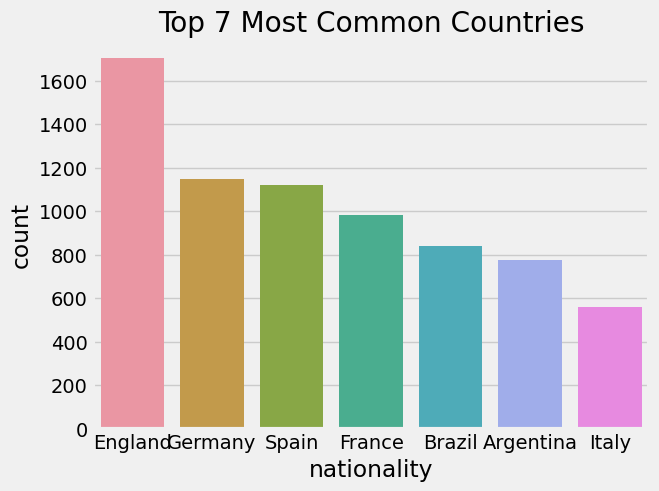

In [31]:
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='nationality', data = df2, order = df2.nationality.value_counts().iloc[:7].index).set_title('Top 7 Most Common Countries')

Top 7 most common countries are: UK, Germany, Spain, France, Brazil, Argentina and Italy.

Text(0.5, 1.0, 'Top 5 most Players per Club')

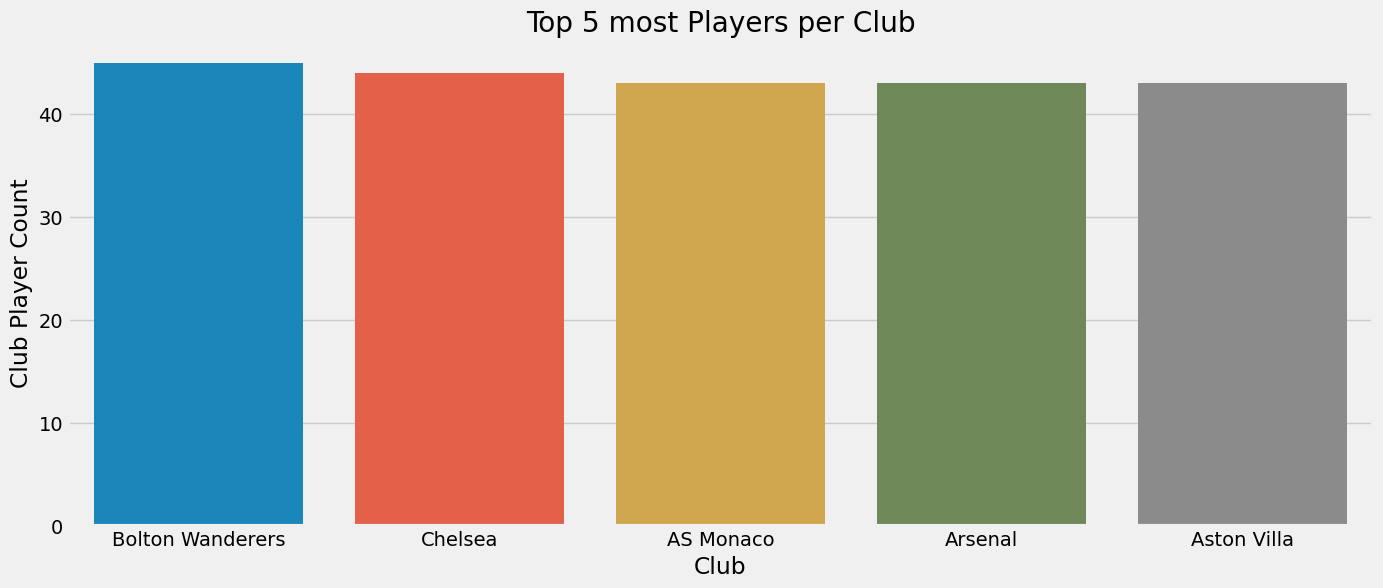

In [32]:
plt.figure(figsize = (15,6))
ax = sns.countplot(x = 'club', data = df2, order = df2.club.value_counts().iloc[:5].index)
ax.set_xlabel(xlabel = 'Club')
ax.set_ylabel(ylabel = 'Club Player Count')
ax.set_title(label = 'Top 5 most Players per Club')

Top 5 most popular clubs are: Bolton Wanderers, Chelsea, AS Monaco, Assenal and Aston Villa.

Text(0.5, 1.0, 'Players Position')

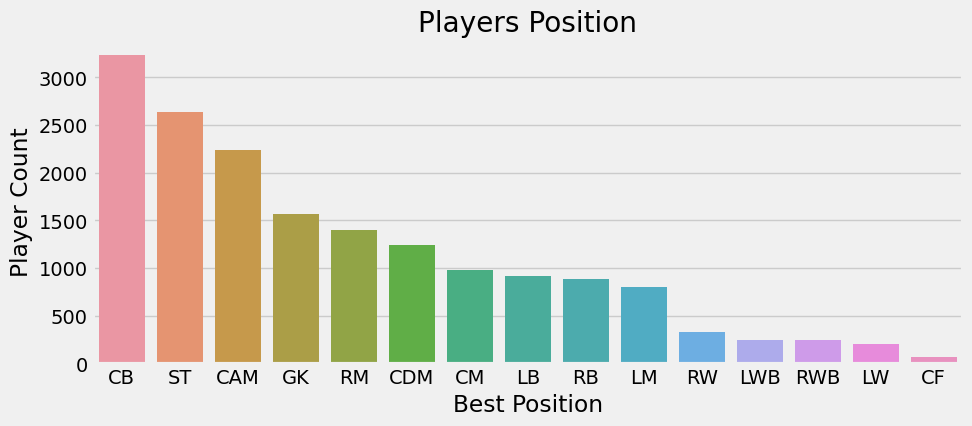

In [33]:
plt.figure(figsize = (10,4))
ax = sns.countplot(x = 'bp', data = df2, order = df2.bp.value_counts().iloc[:15].index)
ax.set_xlabel(xlabel = 'Best Position')
ax.set_ylabel(ylabel = 'Player Count')
ax.set_title(label = 'Players Position')

CB – Center Back. Normally one or two center backs are used in a formation.

ST – Striker. A similar function as the center and wing forward.

CAM - Central Attacking Midfielder. Operate between a team's central midfield and its forwards.

GK – Goalkeeper. 

RM/LM - Right/Left Midfielder. They are positioned closer to the touchlines of the field to balance between defense and attack.

CDM - Central Defensive Midfielder.

CM - Central Midfielder.

LB/RB - Left/Right Back.

RW/LW – right/left wing. Similar to the right wing back, but usually with a primarily offensive task. In other words, an offensive wing midfielder.

LWB – left wing back. Positioned in front of the left back and out on the “wing”.

RWB – right wing back. Positioned in front of the right back.

CF – center forward. The attacker that is positioned in the middle of the offensive line.

Text(0, 0.5, 'Player Count')

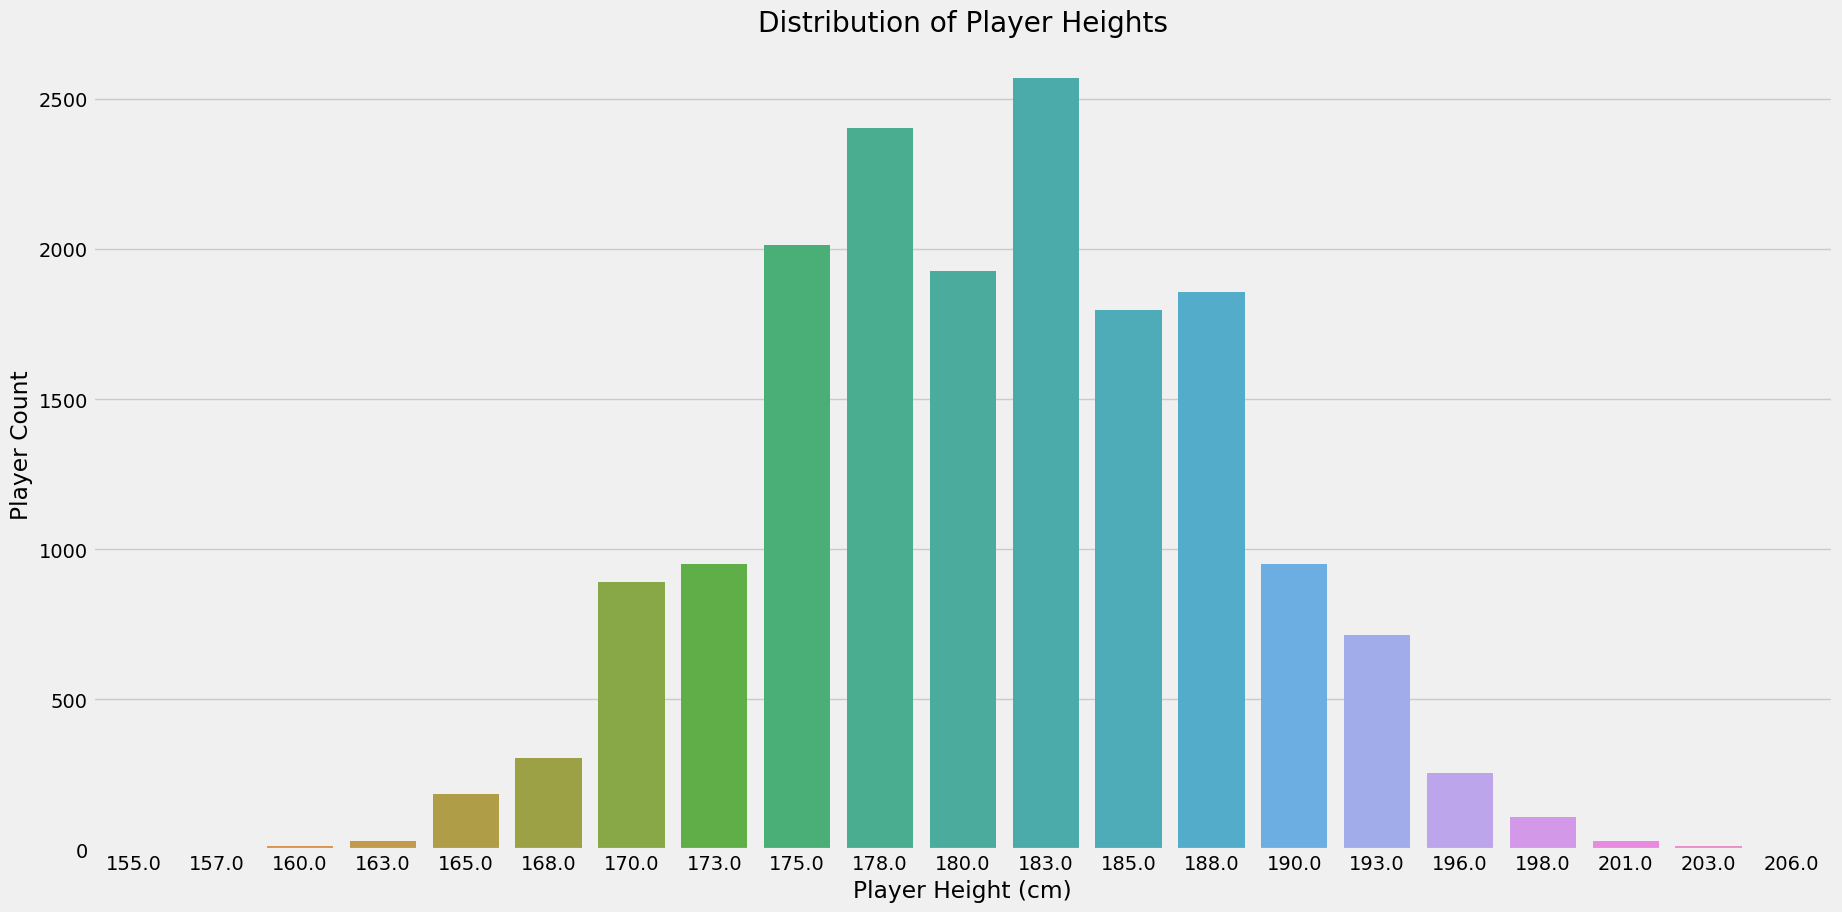

In [34]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x = 'height', data = df2)
ax.set_title(label = 'Distribution of Player Heights')
ax.set_xlabel(xlabel = 'Player Height (cm)')
ax.set_ylabel(ylabel = 'Player Count')

Height of the player is a normal distribution [170cm;193cm]

Text(0, 0.5, 'Player Count')

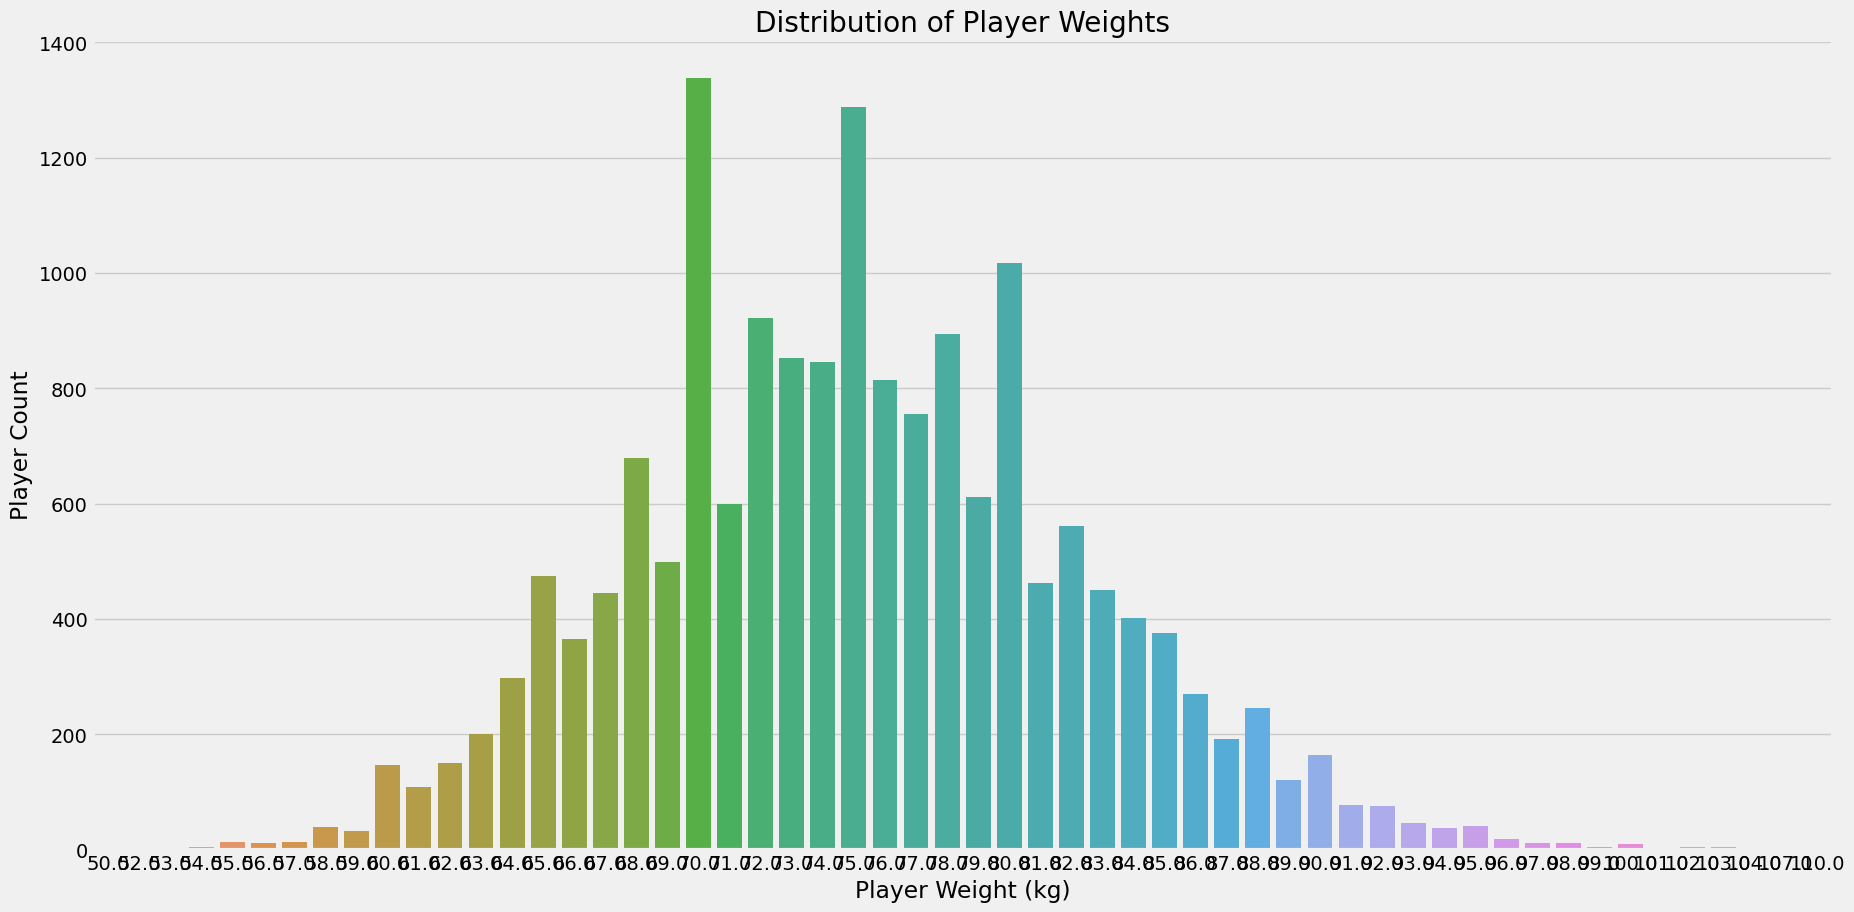

In [35]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x = 'weight', data = df2)
ax.set_title(label = 'Distribution of Player Weights')
ax.set_xlabel(xlabel = 'Player Weight (kg)')
ax.set_ylabel(ylabel = 'Player Count')

Weight of the player is a normal distribution [60kg;90kg]

#### Rank the Players by value

In [36]:
df2_sort_age = df2.sort_values('value',ascending=False)
df2_sort_age.iloc[0:10,0:15]

,name,age,ova,nationality,club,bp,pot,height,weight,value,wage,finishing,heading_accuracy,fk_accuracy,ball_control
9331,K. Mbappé,21,90,France,Paris Saint-Germain,ST,95,178.0,73.0,105500000.0,160000.0,91,73,63,90
2650,Neymar Jr,28,91,Brazil,Paris Saint-Germain,LW,91,175.0,68.0,90000000.0,270000.0,87,62,89,95
2871,K. De Bruyne,29,91,Belgium,Manchester City,CAM,91,180.0,70.0,87000000.0,370000.0,82,55,83,92
2287,R. Lewandowski,31,91,Poland,FC Bayern München,ST,91,183.0,80.0,80000000.0,240000.0,94,85,85,88
5109,M. Salah,28,90,Egypt,Liverpool,RW,90,175.0,71.0,78000000.0,250000.0,91,59,69,89
5030,S. Mané,28,90,Senegal,Liverpool,LW,90,175.0,69.0,78000000.0,250000.0,90,84,64,89
4166,V. van Dijk,28,90,Netherlands,Liverpool,CB,91,193.0,92.0,75500000.0,210000.0,52,87,70,77
3665,J. Oblak,27,91,Slovenia,Atlético Madrid,GK,93,188.0,87.0,75000000.0,125000.0,11,15,14,30
4049,R. Sterling,25,88,England,Manchester City,LW,90,170.0,69.0,72500000.0,270000.0,85,46,63,88
5425,P. Dybala,26,88,Argentina,Juventus,CAM,89,178.0,75.0,71000000.0,190000.0,84,64,88,94


From this ranking we can see that Mbappé has the highest value, following by Neymar, Bruyne, Lewandowski, Salah, Mané, Dijik and Oblak.

My wild guess is that the value of these footballers doesn't depend only on their wages, or their outstanding performances, since Mbappé doesn't have the highest stats.

<AxesSubplot:xlabel='age', ylabel='value'>

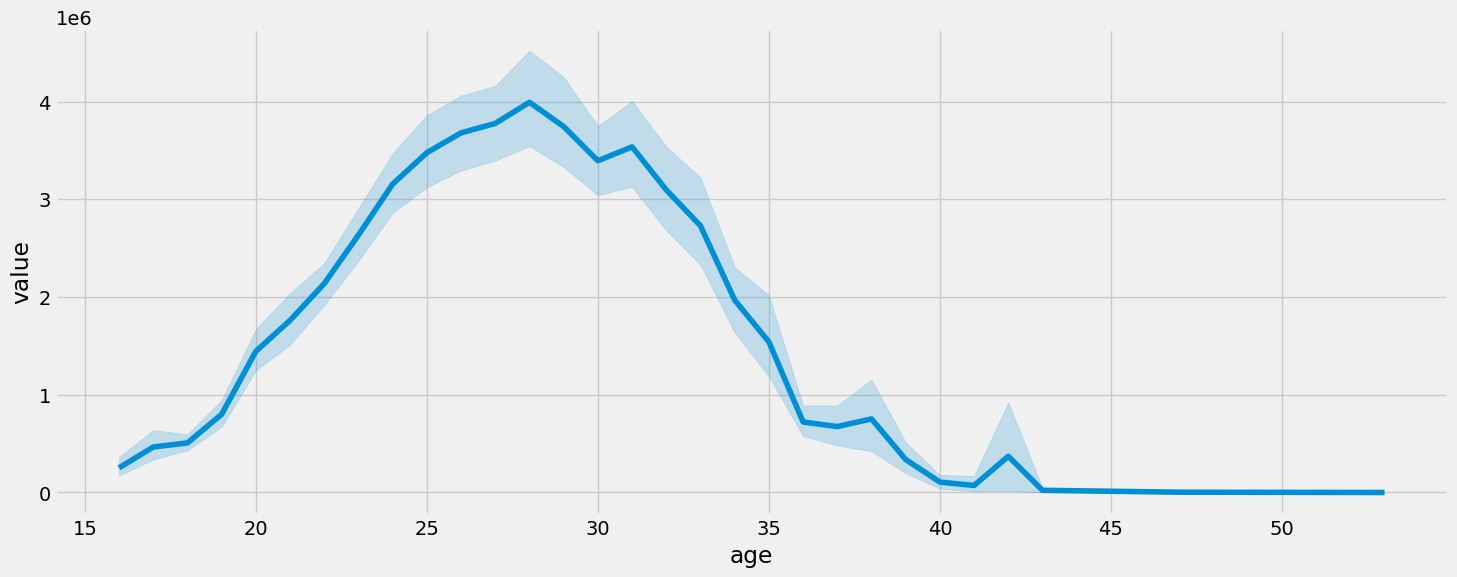

In [37]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df2 , x="age", y="value")

Footballers seem to reach their peak value between age 24 and 32.

<AxesSubplot:xlabel='age', ylabel='wage'>

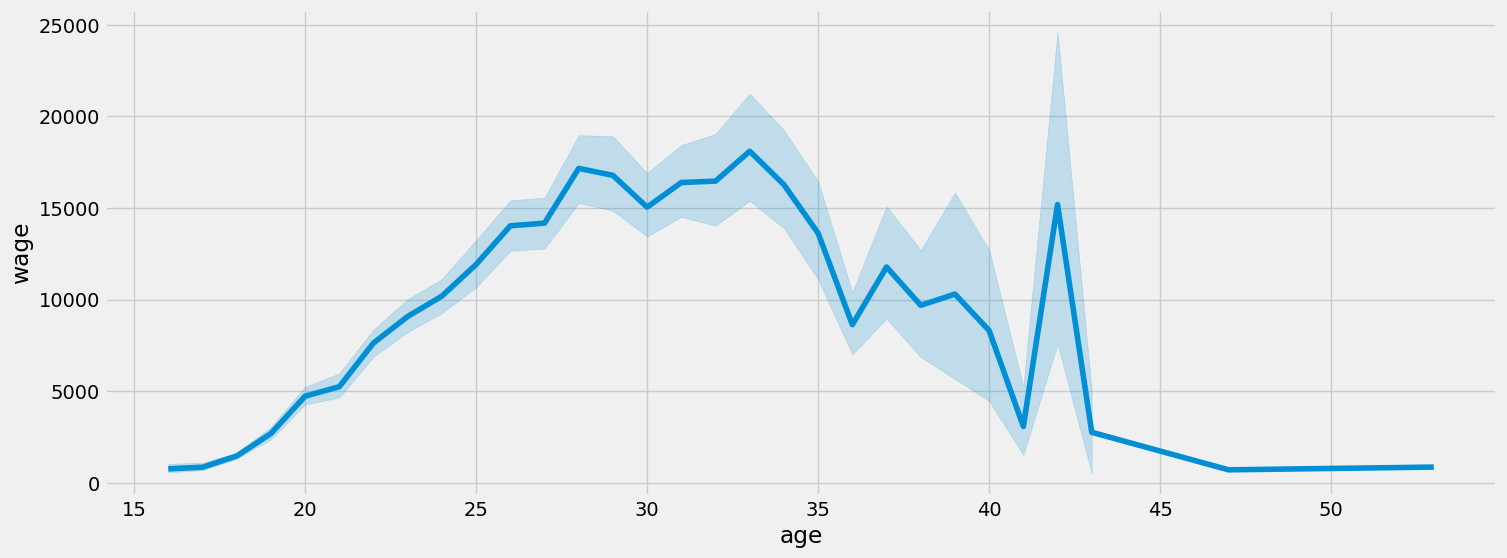

In [38]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df2 , x="age", y="wage")

From the two graphes, we can see the correlation between "wage" and "value" until the age of 36, where there are some middle-aged footballers who get paid even higher than the younger ones (they might be outliers)

<AxesSubplot:xlabel='age', ylabel='ova'>

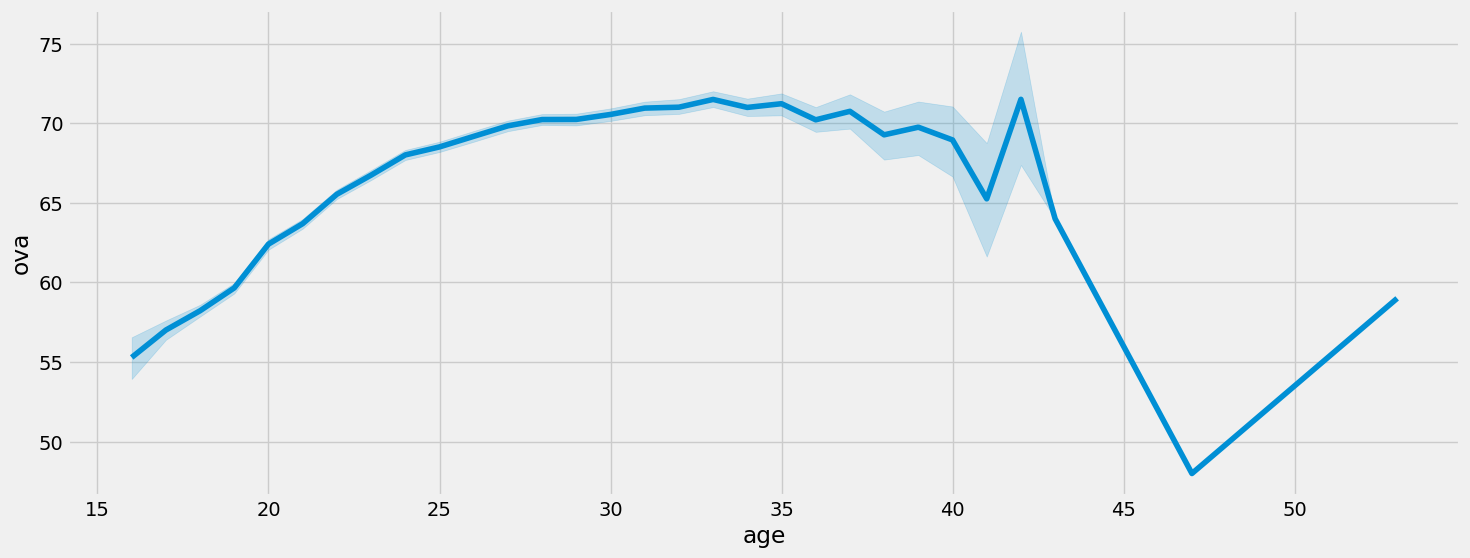

In [39]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df2 , x="age", y="ova")

Footballers improve their performance rapidly from age 15 to 25, after that they progress much slower, and starting from age 35 their performance start to go down. (again, we see some outliers here)

#### Highlight the top players by 'ova'

In [40]:
df2_sort_ova = df2.sort_values('ova',ascending=False)
df2_sort_ova.iloc[0:10,0:15]

,name,age,ova,nationality,club,bp,pot,height,weight,value,wage,finishing,heading_accuracy,fk_accuracy,ball_control
752,L. Messi,33,93,Argentina,FC Barcelona,RW,93,170.0,72.0,67500000.0,560000.0,95,70,94,96
142,Cristiano Ronaldo,35,92,Portugal,Juventus,ST,92,188.0,83.0,46000000.0,220000.0,95,90,76,92
3665,J. Oblak,27,91,Slovenia,Atlético Madrid,GK,93,188.0,87.0,75000000.0,125000.0,11,15,14,30
2287,R. Lewandowski,31,91,Poland,FC Bayern München,ST,91,183.0,80.0,80000000.0,240000.0,94,85,85,88
2650,Neymar Jr,28,91,Brazil,Paris Saint-Germain,LW,91,175.0,68.0,90000000.0,270000.0,87,62,89,95
2871,K. De Bruyne,29,91,Belgium,Manchester City,CAM,91,180.0,70.0,87000000.0,370000.0,82,55,83,92
2790,M. ter Stegen,28,90,Germany,FC Barcelona,GK,93,188.0,85.0,69500000.0,260000.0,14,11,12,30
5030,S. Mané,28,90,Senegal,Liverpool,LW,90,175.0,69.0,78000000.0,250000.0,90,84,64,89
5777,Alisson,27,90,Brazil,Liverpool,GK,91,190.0,91.0,62500000.0,160000.0,13,19,18,30
9331,K. Mbappé,21,90,France,Paris Saint-Germain,ST,95,178.0,73.0,105500000.0,160000.0,91,73,63,90


Ranking by Overall Performance, Messi is classed the first, followed up by Ronaldo, Oblak, Lewandowski, Neymar, Bruyne, Stegen, Mané, Alisson, and interestingly Mbappé is only the 10th, as we have predicted before.

In [41]:
# check the correlation
mask = np.zeros_like(df2.corr())

# display only half of the matrix
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

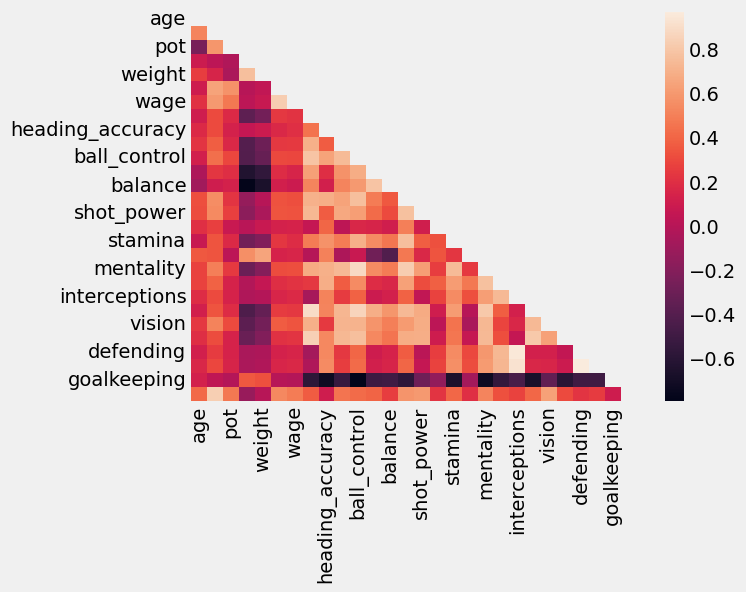

In [42]:
sns.heatmap(df2.corr(),mask=mask)

# Data Preprocessing

In [43]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17018 entries, 0 to 17124
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              17018 non-null  object 
 1   age               17018 non-null  int64  
 2   ova               17018 non-null  int64  
 3   nationality       17018 non-null  object 
 4   club              17018 non-null  object 
 5   bp                17018 non-null  object 
 6   pot               17018 non-null  int64  
 7   height            17018 non-null  float64
 8   weight            17018 non-null  float64
 9   value             17018 non-null  float64
 10  wage              17018 non-null  float64
 11  finishing         17018 non-null  int64  
 12  heading_accuracy  17018 non-null  int64  
 13  fk_accuracy       17018 non-null  int64  
 14  ball_control      17018 non-null  int64  
 15  agility           17018 non-null  float64
 16  balance           17018 non-null  float6

In [44]:
df2.describe().apply(lambda x: round(x,0))

,age,ova,pot,height,weight,value,wage,finishing,heading_accuracy,fk_accuracy,...,mentality,aggression,interceptions,positioning,vision,penalties,defending,marking,goalkeeping,base_stats
count,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,...,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0,17018.0
mean,25.0,67.0,72.0,181.0,75.0,2583519.0,10599.0,48.0,54.0,44.0,...,262.0,57.0,47.0,52.0,55.0,50.0,142.0,47.0,78.0,361.0
std,5.0,7.0,6.0,7.0,7.0,5385616.0,21195.0,19.0,17.0,17.0,...,63.0,17.0,21.0,19.0,14.0,16.0,62.0,20.0,81.0,40.0
min,16.0,45.0,47.0,155.0,50.0,0.0,0.0,3.0,5.0,5.0,...,50.0,9.0,4.0,2.0,10.0,7.0,20.0,3.0,5.0,228.0
25%,21.0,62.0,69.0,175.0,70.0,375000.0,1000.0,33.0,46.0,32.0,...,235.0,45.0,26.0,43.0,47.0,40.0,85.0,30.0,48.0,333.0
50%,25.0,67.0,72.0,180.0,75.0,800000.0,3000.0,52.0,57.0,43.0,...,270.0,60.0,53.0,57.0,57.0,51.0,159.0,52.0,53.0,362.0
75%,29.0,72.0,76.0,185.0,80.0,2400000.0,11000.0,64.0,65.0,58.0,...,304.0,70.0,65.0,66.0,65.0,62.0,194.0,64.0,59.0,389.0
max,53.0,93.0,95.0,206.0,110.0,105500000.0,560000.0,95.0,93.0,94.0,...,421.0,96.0,93.0,95.0,95.0,94.0,272.0,94.0,440.0,498.0


From the above, almost all columns about "performance stats" have range from (0:100) but there are a few which need scaling: power, mentality, defending, goalkeeping.

In [45]:
num2 = df2.select_dtypes(include=np.number)
cat2 = df2.select_dtypes(include='object')

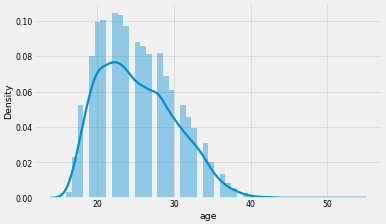

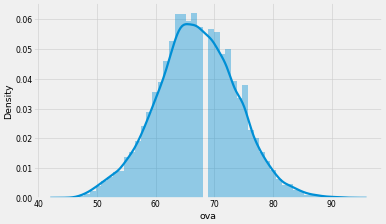

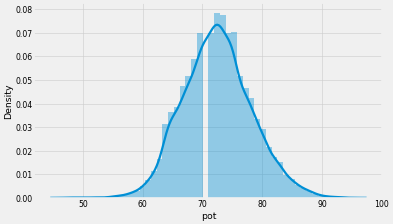

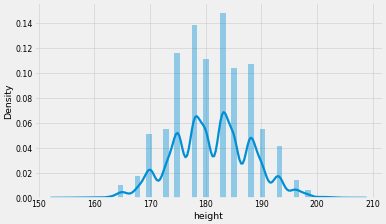

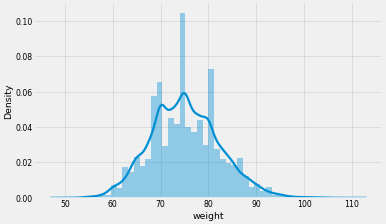

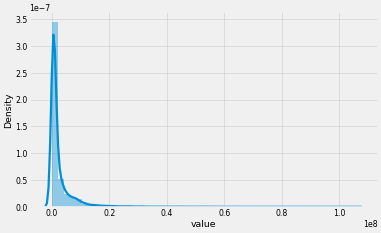

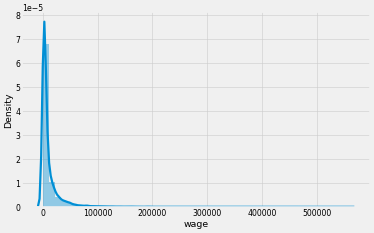

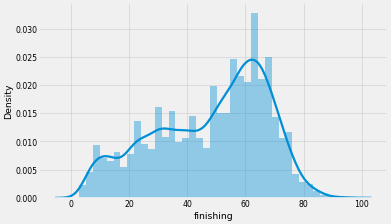

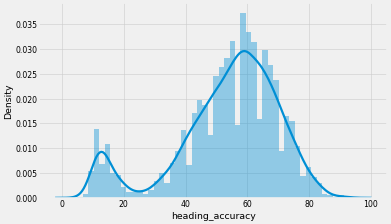

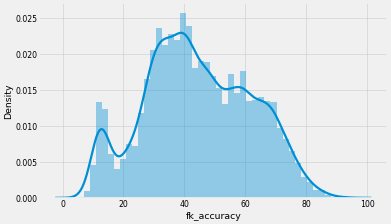

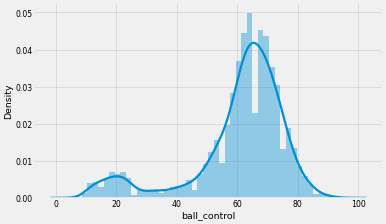

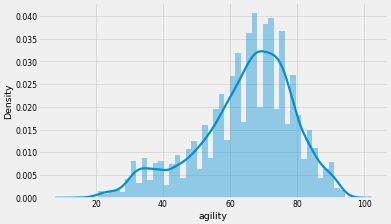

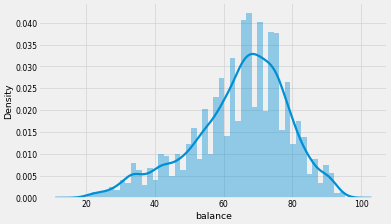

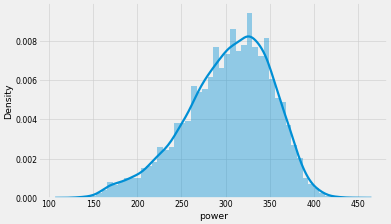

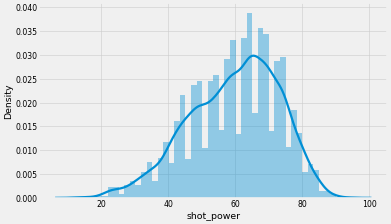

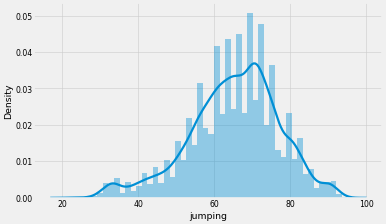

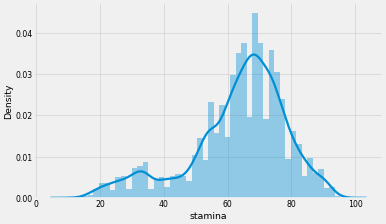

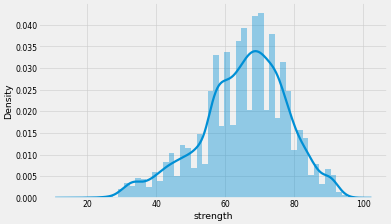

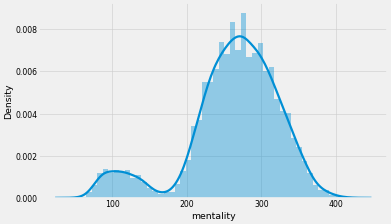

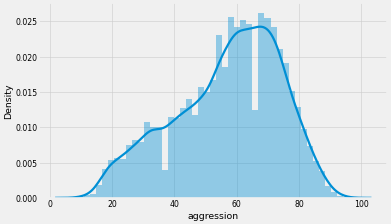

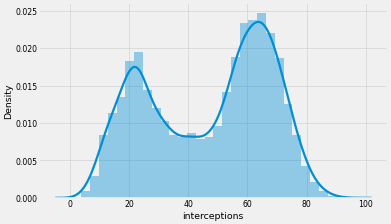

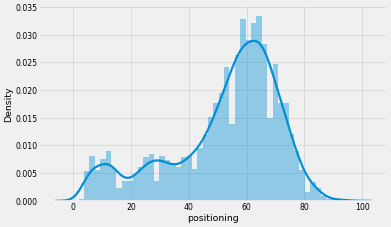

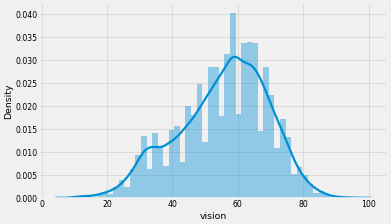

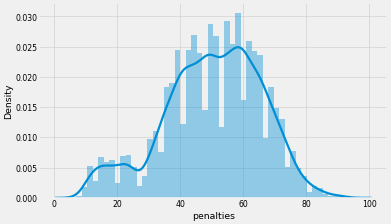

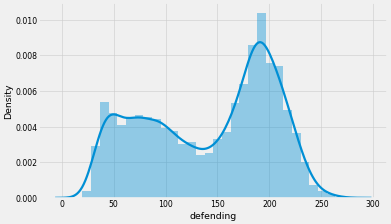

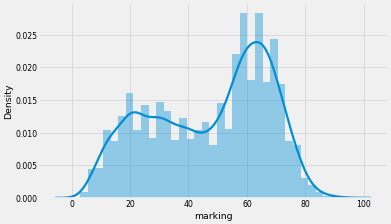

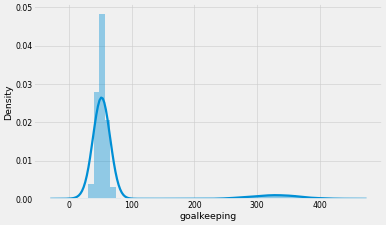

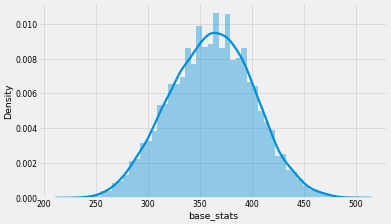

In [46]:
for column in num2.columns:
    figure(figsize=(10, 6), dpi=40)
    sns.distplot(num2[column])
    plt.show()

In [47]:
# BoxCox transformation

def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

In [48]:
df2, _ci = boxcox_transform(df2)

# I won't be encoding categorical variables right now 
# so I'm going to run linear regression on num2

num2 = df2.select_dtypes(include=np.number)
num2

,age,ova,pot,height,weight,value,wage,finishing,heading_accuracy,fk_accuracy,...,mentality,aggression,interceptions,positioning,vision,penalties,defending,marking,goalkeeping,base_stats
0,2.342709,57.034857,13.063356,61.851375,5.431436,8.982569,6.151030,93.337391,641.773835,34.913063,...,69895.605015,361.918137,62.323396,442.676380,351.232801,131.304248,222.247917,89.247792,1.027305,574.714060
1,2.390326,58.627070,13.264877,60.573138,5.086951,8.965131,6.151030,126.137598,679.643805,44.186455,...,90100.627015,354.550531,64.110263,546.919229,408.492806,224.693854,162.402184,89.247792,1.027305,540.116396
2,2.342709,58.627070,13.264877,59.801676,5.258136,9.219433,6.489386,126.137598,343.106610,43.229776,...,68553.086851,339.960821,35.325618,511.275865,416.903689,189.710462,103.990650,41.813501,1.025189,493.709120
4,2.379044,66.553385,14.229252,58.508134,5.153279,9.848803,6.392658,138.243252,551.104512,39.847316,...,94248.477192,263.316323,63.216999,620.814510,587.046784,208.969953,192.831934,86.475780,1.022046,592.818422
5,2.255876,54.641863,13.164505,59.285439,5.278322,9.045586,5.994281,100.220071,357.636514,25.651363,...,44147.911418,297.383165,23.470037,442.676380,289.397298,117.549590,82.476775,24.993239,1.022626,502.670262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,2.162713,53.043304,13.063356,65.632471,5.298261,8.927812,5.543135,35.952099,778.249722,20.775845,...,31712.023570,339.960821,52.469868,89.439293,102.201823,94.399895,211.345404,76.824364,1.017962,416.498737
17121,2.066746,46.621281,12.755065,60.573138,5.337425,8.277990,5.747261,77.621765,482.765970,29.836900,...,45219.776694,217.901222,45.272862,356.992952,252.810773,131.304248,139.638585,40.499617,1.027685,441.647793
17122,2.066746,46.621281,12.858654,59.801676,5.196036,8.277990,5.543135,58.208207,533.666475,21.327752,...,44147.911418,263.316323,49.774287,297.278190,197.787137,127.831451,173.260340,68.619165,1.018726,417.975472
17123,2.117725,51.442060,13.463355,59.801676,5.131470,8.864462,5.747261,41.837121,516.463192,27.759554,...,44503.730505,283.598604,52.469868,268.949196,274.566937,84.865201,191.743762,71.346918,1.025189,465.401318


### Split data into training and test sets

In [49]:
# X-y split
X = num2.drop('ova', axis=1)
y = num2['ova']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Predictive Model

In [50]:
# start the model
model = LinearRegression()
# train the model
model.fit(X_train, y_train)

LinearRegression()

# Analyzing Results

In [51]:
# get predictions
predictions = model.predict(X_test)

In [52]:
# get metrics
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.9662125973914558, 0.6963819914288855, 1.0040087992679612)

In [53]:
# MAE and MSE are log transformed
# have to inverse transform
from scipy.special import inv_boxcox

predictions = inv_boxcox(predictions, _ci['ova'])
y_test = inv_boxcox(y_test, _ci['ova'])

In [54]:
mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.8722205207133655, 1.2570867884393715)

In [55]:
import math

results = pd.DataFrame()
results['true'] = inv_boxcox(y_test, _ci['ova'])
results['pred'] = predictions
results['resid'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results

,true,pred,resid
16114,87.910750,71.477274,16.433475
14935,67.701764,56.345338,11.356426
16761,75.246693,63.172389,12.074304
4675,79.034715,66.132392,12.902323
14460,82.832510,66.269245,16.563265
...,...,...,...
11021,81.565518,66.619655,14.945863
5718,100.673806,81.450367,19.223438
6745,67.701764,55.584684,12.117080
6925,85.369603,70.338321,15.031282


In [56]:
results.sort_values('resid', ascending=False).head(50)

,true,pred,resid
71,77.770934,49.846830,27.924105
9331,110.947823,84.805366,26.142457
2650,112.235775,87.319729,24.916046
117,101.955096,77.052725,24.902372
3630,109.660672,84.908562,24.752110
...,...,...,...
211,98.113859,76.716362,21.397497
4188,101.955096,80.612469,21.342627
598,94.280678,72.944113,21.336565
7009,101.955096,80.632673,21.322423


In [57]:
results[results['true'] >= 40]

,true,pred,resid
16114,87.910750,71.477274,16.433475
14935,67.701764,56.345338,11.356426
16761,75.246693,63.172389,12.074304
4675,79.034715,66.132392,12.902323
14460,82.832510,66.269245,16.563265
...,...,...,...
11021,81.565518,66.619655,14.945863
5718,100.673806,81.450367,19.223438
6745,67.701764,55.584684,12.117080
6925,85.369603,70.338321,15.031282


In [58]:
results.describe()

,true,pred,resid
count,5106.000000,5106.000000,5106.000000
mean,81.675627,67.044740,14.630887
std,8.667426,6.721011,2.402651
min,56.470157,43.363481,0.099485
25%,76.508255,62.627917,13.315812
50%,81.565518,66.703507,14.740823
75%,87.910750,71.833143,15.883358
max,112.235775,89.193620,27.924105


<AxesSubplot:xlabel='true', ylabel='pred'>

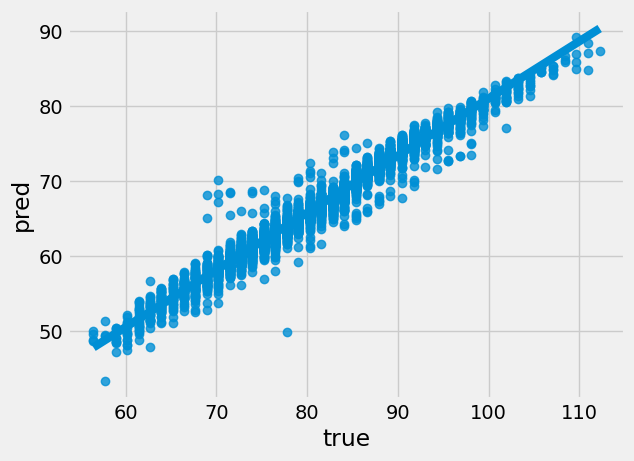

In [59]:
sns.regplot(x=results['true'], y=results['pred'])

#### Feature Selection with Permutation Importance

I want to know which features contribute the most to the model.

In [60]:
# pip install eli5

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state = 0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.4186 ± 0.0131,value
0.2528 ± 0.0123,age
0.1270 ± 0.0039,pot
0.0929 ± 0.0012,base_stats
0.0311 ± 0.0014,ball_control
0.0114 ± 0.0007,shot_power
0.0111 ± 0.0011,interceptions
0.0092 ± 0.0004,heading_accuracy
0.0069 ± 0.0002,wage
0.0062 ± 0.0003,penalties


# Comment:

I might want to keep 'bov' as a feature in the model.


Another analysis approach: analyze based on each position of the player.